In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
#from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

from qiskit.circuit import Parameter, ParameterVector

#from qiskit.visualization import plot_state_city
from qiskit.opflow import Z, I
from qiskit.opflow import StateFn
from qiskit.opflow import I, X, Y, Z, H, CX, Zero
from qiskit.opflow import Gradient

from qiskit.circuit.library import RealAmplitudes

from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit import Aer
from qiskit.utils import QuantumInstance

#from qiskit.algorithms.optimizers import GradientDescent

#from qiskit.opflow import NaturalGradient
from qiskit.algorithms.optimizers import QNSPSA, SPSA


In [2]:

backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)

In [3]:
# 4 random starting states: 
states = []
states.append((I ^ I ^ I ^ I) @ Zero)
states.append((I ^ I ^ I ^ X) @ Zero)
states.append((I ^ I ^ X ^ X) @ Zero)
states.append((I ^ X ^ X ^ X) @ Zero)


In [4]:

# 4 Hamiltonians for target states: (minus sign to target to use minimization later on)
hams = []
hams.append(-1/4 * (Z + I) ^ (Z + I) ^ Z ^ Z)
hams.append(-1/4 * (Z + I) ^ Z ^ (Z + I) ^ Z)
hams.append(-1/4 * Z ^ (Z + I) ^ Z ^ (Z + I))
hams.append(-1/4 * Z ^ Z ^ (Z + I) ^ (Z + I))


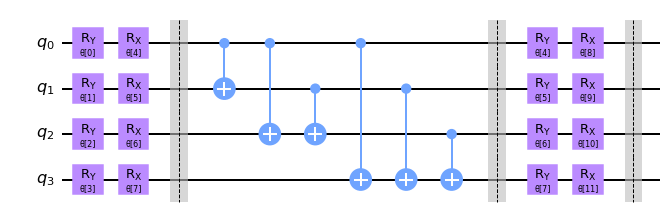

In [5]:
# Variational Quantum Circuit:
#Set the number of layers and qubits
n=4
num_layers = 1

#ParameterVectors are initialized with a string identifier and an integer specifying the vector length
parameters = ParameterVector('θ', n*(num_layers+2))


circuit = QuantumCircuit(n)
for layer in range(num_layers):
    #Appending the parameterized Ry gates using parameters from the vector constructed above
    for i in range(n):
        circuit.ry(parameters[n*layer+i], i)
        circuit.rx(parameters[n*(layer+1)+i], i)

    circuit.barrier()

    #Appending the entangling CNOT gates
    for i in range(n):
        for j in range(i):
                circuit.cx(j,i)
    circuit.barrier()

#Appending one additional layer of parameterized Ry gates
for i in range(n):
    circuit.ry(parameters[n*num_layers+i], i)
    circuit.rx(parameters[n*(num_layers+1)+i], i)

circuit.barrier()

circuit.draw('mpl')


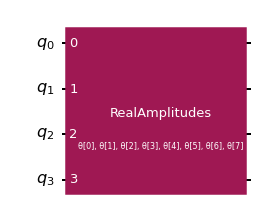

In [6]:
# or maybe use an "easier" predefined ansatz..
ansatz = RealAmplitudes(num_qubits=4, reps=1, entanglement='linear')
ansatz.draw('mpl', style='iqx')

In [12]:
# define the expectation values to minimize (due to the minus sign above) with the corresponding Hamiltonians
# and starting states
expectation = []
expectation.append(StateFn(hams[0], is_measurement=True).compose(StateFn(circuit, is_measurement=True)).compose(StateFn(states[0])))
expectation.append(StateFn(hams[1], is_measurement=True).compose(StateFn(circuit, is_measurement=True)).compose(StateFn(states[1])))
expectation.append(StateFn(hams[2], is_measurement=True).compose(StateFn(circuit, is_measurement=True)).compose(StateFn(states[2])))
expectation.append(StateFn(hams[3], is_measurement=True).compose(StateFn(circuit, is_measurement=True)).compose(StateFn(states[3])))

In [28]:
# use the SPSA minimizer

init = np.random.rand(circuit.num_parameters)

sampler = CircuitSampler(q_instance)

def evaluate(x):
    exp = StateFn(hams[0], is_measurement=True).compose(StateFn(circuit))   
    #exp = expectation[0]
    value_dict = dict(zip(circuit.parameters, x))
    result = sampler.convert(PauliExpectation().convert(exp), params=value_dict).eval()  
    return np.real(result)   


autospsa = SPSA(maxiter=300)#, learning_rate=None, perturbation=None, callback=autospsa_callback)

spsa_result = autospsa.optimize(init.size, evaluate, initial_point=init)

print(spsa_result)

(array([-0.75524579,  0.00749435, -0.00846628,  0.69276782,  1.5664993 ,
       -0.00638182,  0.00254248, -0.97447432,  0.7537927 ,  1.56008301,
        0.00517895,  0.67931324]), -0.9999999999999998, 600)


(array([-0.75524579,  0.00749435, -0.00846628,  0.69276782,  1.5664993 ,
       -0.00638182,  0.00254248, -0.97447432,  0.7537927 ,  1.56008301,
        0.00517895,  0.67931324]), -0.9999999999999998, 600)


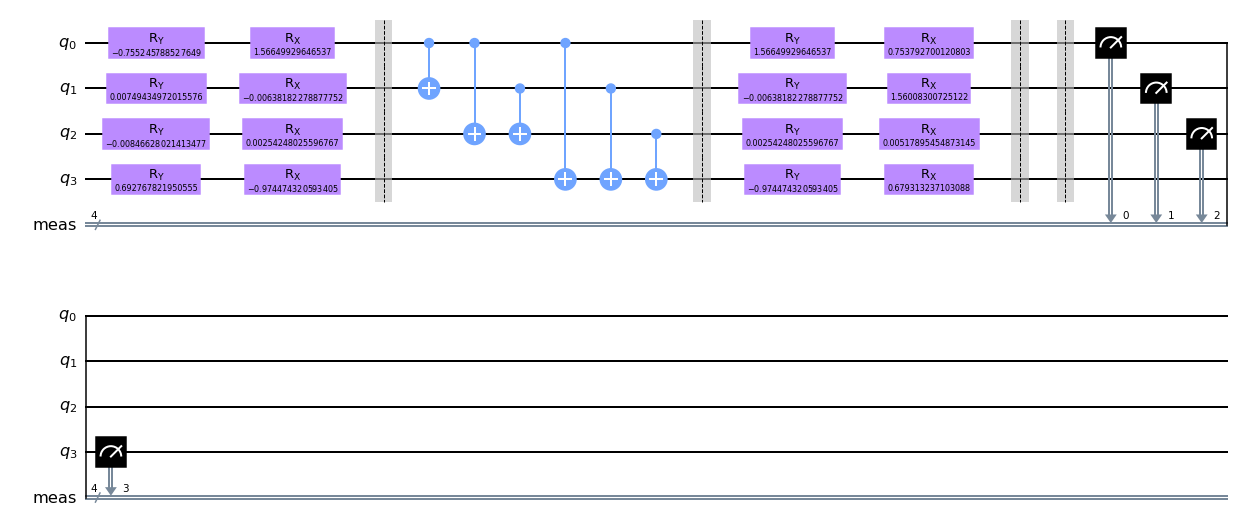

In [29]:
# test for state 0
print(spsa_result)
#Create parameter dictionary with random values to bind

#Assign parameters using the assign_parameters method
bound_circuit = circuit.assign_parameters(parameters = spsa_result[0])
bound_circuit.measure_all()
bound_circuit.draw('mpl')

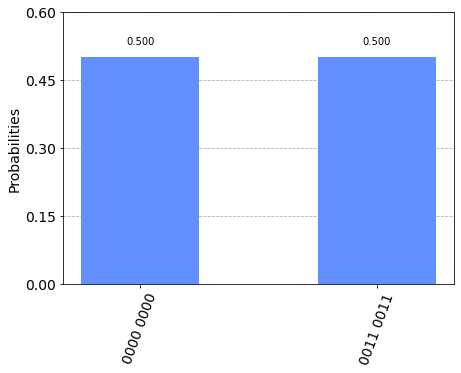

In [31]:

backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
counts = execute(bound_circuit, backend, shots = 1000).result().get_counts() # we run the simulation and get the counts
plot_histogram(counts) # let us plot a histogram to see the possible outcomes and corresponding probabilities

In [ ]:
# TODO: 
# figure out correct Hamiltonian for correct cost function
# Loop over all input states and design an combined optimization for all the input + output states

# Unfortunately could not finish before Deadline